In [9]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as f
import matplotlib.pyplot as plt

In [2]:
try:
    sc = ps.SparkContext("local[*]",'test')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


In [3]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data/cleanedReviews.csv')
df = df.dropna()
df.show()
df.count()

+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|one review mentio...| positive|
|wonder littl prod...| positive|
|thought wonder wa...| positive|
|basic there famil...| negative|
|petter mattei lov...| positive|
|probabl alltim fa...| positive|
|sure would like s...| positive|
|show amaz fresh i...| negative|
|encourag posit co...| negative|
|like origin gut w...| positive|
|phil alien one qu...| negative|
|saw movi came rec...| negative|
|im big fan boll w...| negative|
|cast play shakesp...| negative|
|fantast movi thre...| positive|
|kind drawn erot s...| negative|
|film simpli remad...| positive|
|movi made one top...| negative|
|rememb filmit fir...| positive|
|aw film must real...| negative|
+--------------------+---------+
only showing top 20 rows



50000

In [4]:
(train_set, val_set) = df.randomSplit([0.9, 0.1], seed = 300)
print(train_set.count(),val_set.count())

44948 5052


In [5]:
def tf_idf(textCol,labelCol):
    tokenizer = Tokenizer(inputCol=textCol, outputCol="words")
    hashtf = HashingTF(numFeatures=1000, inputCol="words", outputCol='tf')
    idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5)
    label_stringIdx = StringIndexer(inputCol = labelCol, outputCol = "label")
    lr = LogisticRegression(maxIter=100)
    pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])
    return pipeline

def cv_idf(textCol,labelCol):
    tokenizer = Tokenizer(inputCol=textCol, outputCol="words")
    cv = CountVectorizer(vocabSize=1000, inputCol="words", outputCol='cv')
    idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5)
    label_stringIdx = StringIndexer(inputCol = labelCol, outputCol = "label")
    lr = LogisticRegression(maxIter=100)
    pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])
    return pipeline

In [8]:
%%time
pipelineFit = cv_idf("review","sentiment").fit(train_set)

predictions = pipelineFit.transform(val_set)
predictions.show()

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print(accuracy,roc_auc)

+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|              review|sentiment|               words|                  cv|            features|label|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|` seen movi twice...| positive|[`, seen, movi, t...|(1000,[0,4,7,10,1...|(1000,[0,4,7,10,1...|  1.0|[0.13067514868892...|[0.53262237874848...|       0.0|
|absolut best movi...| positive|[absolut, best, m...|(1000,[0,4,10,13,...|(1000,[0,4,10,13,...|  1.0|[-1.8992577419421...|[0.13019250638998...|       1.0|
|absolut love film...| positive|[absolut, love, f...|(1000,[0,1,3,9,10...|(1000,[0,1,3,9,10...|  1.0|[-0.6418972003319...|[0.34481780067182...|       1.0|
|absolut noth rede...| negative|[absolut, noth, r...|(1000,[1,2,8,12,1

+-------+-----+
|   word|count|
+-------+-----+
|   film|49021|
|   movi|43129|
|    one|26958|
|   like|19885|
|   time|15480|
|    see|14687|
|   good|14573|
|  stori|13654|
|charact|13630|
|   make|13167|
|  great|12798|
|    get|12577|
|  watch|12507|
|   love|12064|
|   well|11309|
|   show|10813|
| realli|10676|
|   also|10550|
|  would|10368|
|   play| 9840|
+-------+-----+
only showing top 20 rows

108517
+-------+-----+
|   word|count|
+-------+-----+
|   movi|55893|
|   film|43095|
|    one|25719|
|   like|23944|
|   make|15402|
|    get|15142|
|   even|15098|
|  watch|14582|
|   time|14360|
|   good|14345|
|    bad|14157|
|charact|13944|
|  would|13631|
|    see|12889|
| realli|12225|
|   look|11315|
|  scene|11013|
|  stori|10582|
|    act|10141|
|   dont|10008|
+-------+-----+
only showing top 20 rows

106286


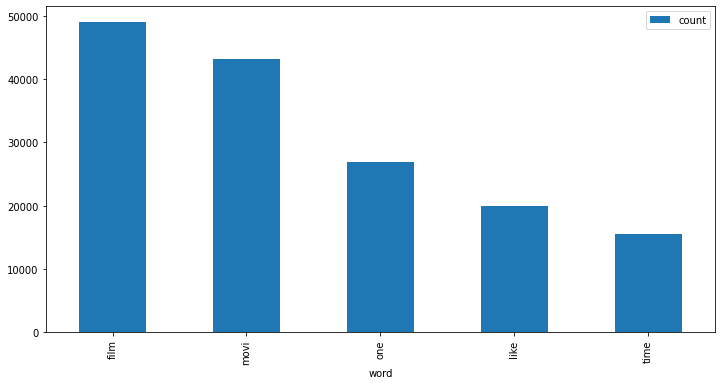

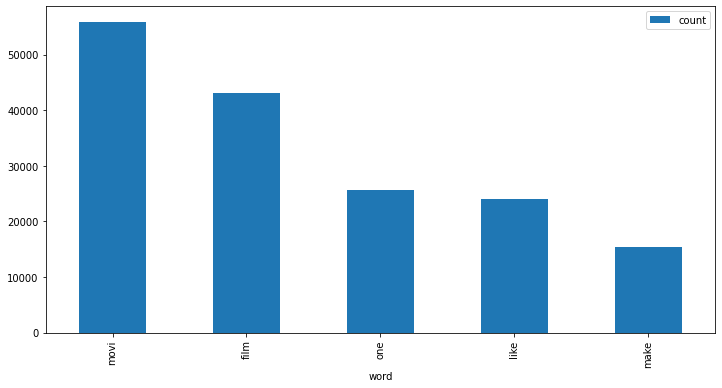

In [10]:
def word_count(sentiment):
    d=df.filter(f.col('sentiment')==sentiment)
    plot = d.withColumn('word', f.explode(f.split(f.col('review'), ' ')))\
        .groupBy('word')\
        .count()\
        .sort('count', ascending=False)
    plot.show()
    print(plot.count())
    pandas_df = plot.toPandas().head(5)
    pandas_df.set_index('word', inplace=True)
    pandas_df.plot(kind='bar',figsize=(12,6));

word_count("positive")
word_count("negative")

In [11]:
df.withColumn('count', f.size(f.split(f.col('review'), ' '))).agg({"count": "avg"}).show()

+----------+
|avg(count)|
+----------+
| 118.62438|
+----------+



2542 2510 2568 2484


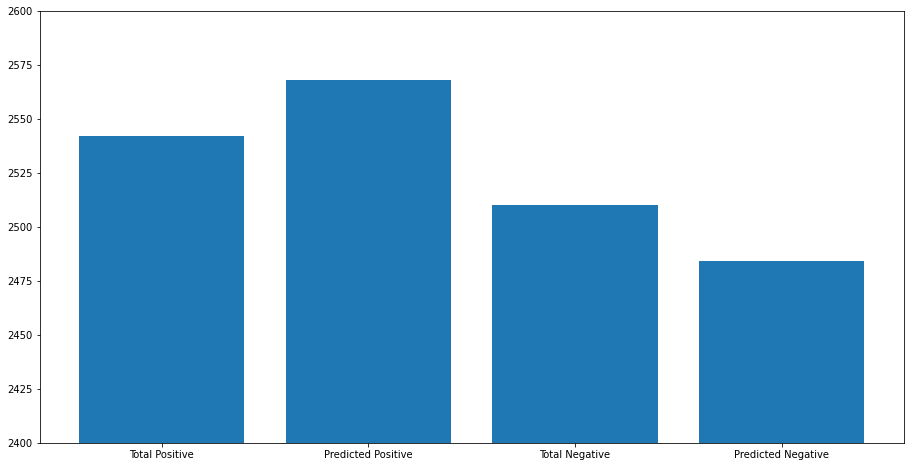

In [12]:
posCount = val_set.filter(df.sentiment=="positive").count()
negCount = val_set.filter(df.sentiment=="negative").count()
posPred = predictions.filter(1.0 == predictions.prediction).count()
negPred = predictions.filter(0.0 == predictions.prediction).count()
print(posCount,negCount,posPred,negPred)

fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
XAxis = ['Total Positive','Predicted Positive','Total Negative','Predicted Negative']
Height = [posCount,posPred,negCount,negPred]
ax.bar(XAxis,Height)
plt.ylim(2400, 2600)
plt.show()

2542 2510 2203 2145


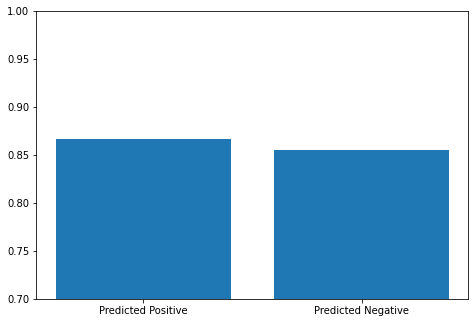

In [13]:
pos = predictions.filter(predictions.label==1.0)
neg = predictions.filter(predictions.label==0.0)
posCount = pos.count()
negCount = neg.count()
posPred = pos.filter(1.0 == predictions.prediction).count()
negPred = neg.filter(0.0 == predictions.prediction).count()
print(posCount,negCount,posPred,negPred)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
XAxis = ['Predicted Positive','Predicted Negative']
Height = [posPred/posCount,negPred/negCount]
ax.bar(XAxis,Height)
plt.ylim(0.7, 1)
plt.show()

In [14]:
def predict_sentence(sentence):
    columns=["review","sentiment"]
    data=[(sentence,"positive")]
    sentenceDF = sqlContext.createDataFrame(data).toDF(*columns)
    prediction = pipelineFit.transform(sentenceDF)
    if prediction.head().prediction==1.0:
        print("Positive review")
    else:
        print("Negative review")

positive_sentence = '''It is a very good movie'''
predict_sentence(positive_sentence)
negative_sentence = '''This movie will be flop. Its boring'''
predict_sentence(negative_sentence)

Positive review
Negative review


In [15]:
sc.stop()